# 1. EDA & RFM Preprocessing - Online Retail

**Goal:** Transform raw transactional logs into customer-level RFM (Recency, Frequency, Monetary) metrics.

**Dataset:** UCI Online Retail (Real Transactional Data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_style("whitegrid")

## 1. Data Loading & Cleaning

Real data is messy. We expect missing IDs, returns (negative quantities), and outliers.

In [2]:
df = pd.read_excel('../data/raw/Online_Retail.xlsx')

print(f"Original Shape: {df.shape}")
print(f"Missing IDs: {df['CustomerID'].isnull().sum()}")

# 1. Drop missing CustomerIDs (essential for segmentation)
df = df.dropna(subset=['CustomerID'])

# 2. Remove Returns (Quantity < 0)
df = df[df['Quantity'] > 0]

# 3. Calculate Total Price
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print(f"Clean Shape: {df.shape}")
df.head()

Original Shape: (541909, 8)
Missing IDs: 135080


Clean Shape: (397924, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 2. RFM Calculation

- **Recency:** Days since last purchase
- **Frequency:** Number of specific transactions
- **Monetary:** Total spend

In [3]:
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

print("RFM Table Preview:")
display(rfm.head())

# Save for next steps
rfm.to_csv('../data/processed/rfm_data.csv')

RFM Table Preview:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 3. Distribution Analysis (skew checking)

C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


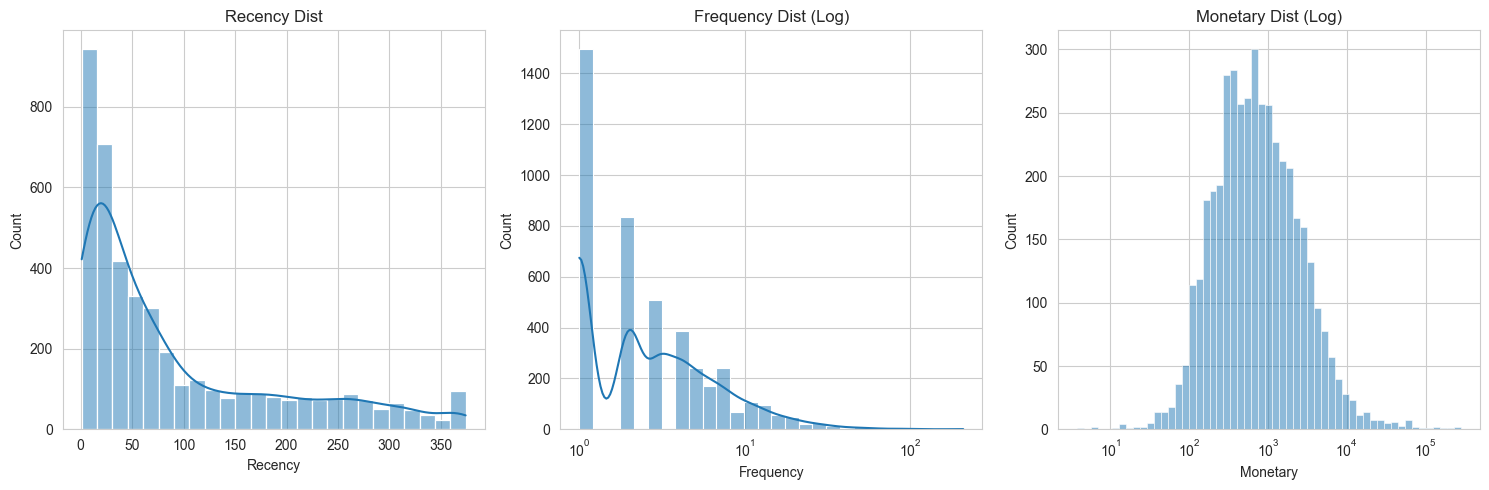

💡 INSIGHT: Real data is heavily skewed! We must log-transform before clustering.


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(rfm['Recency'], kde=True, ax=axes[0])
axes[0].set_title('Recency Dist')

sns.histplot(rfm['Frequency'], kde=True, log_scale=True, ax=axes[1])
axes[1].set_title('Frequency Dist (Log)')

sns.histplot(rfm['Monetary'], kde=True, log_scale=True, ax=axes[2])
axes[2].set_title('Monetary Dist (Log)')

plt.tight_layout()
plt.show()

print("💡 INSIGHT: Real data is heavily skewed! We must log-transform before clustering.")